In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

In [5]:
file_path = 'GPS_Data_Simplified_2D_Feature_Map.xlsx'
df = pd.read_excel(file_path)

In [6]:
# Feature Engineering
def engineer_features(df):
    df['CP_diff'] = 0  # Placeholder for single prediction
    df['CP_consistency'] = 0  # Placeholder for single prediction
    df['signal_quality'] = df['CN0']
    df['PC_PIP_ratio'] = df['PC'] / df['PIP']
    df['EC_LC_ratio'] = df['EC'] / df['LC']
    df['CP_rate'] = 0  # Placeholder for single prediction
    df['PD_rate'] = 0  # Placeholder for single prediction
    df['quality_score'] = ((df['CN0'] >= 45.0) & (np.abs(df['PC'] - df['PIP']) < 1000.0)).astype(int)
    return df

In [7]:
df = engineer_features(df)

In [8]:
features = ['PRN', 'DO', 'PD', 'CP', 'EC', 'LC', 'PC', 'PIP', 'PQP', 'TCD', 'CN0',
            'CP_consistency', 'signal_quality', 'PC_PIP_ratio', 'EC_LC_ratio',
            'CP_rate', 'PD_rate', 'quality_score']
target = 'Output'

In [9]:
X = df[features]
y = LabelEncoder().fit_transform(df[target])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_scaled, y_train)

c:\Users\sidha\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
model.save_model('xgboost_gps_spoofing_model.json')


In [15]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Testing Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))


Testing Accuracy: 92.63%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     79352
           1       0.84      0.76      0.80      7385
           2       0.70      0.72      0.71      8864
           3       0.95      0.93      0.94      6505

    accuracy                           0.93    102106
   macro avg       0.86      0.84      0.85    102106
weighted avg       0.93      0.93      0.93    102106



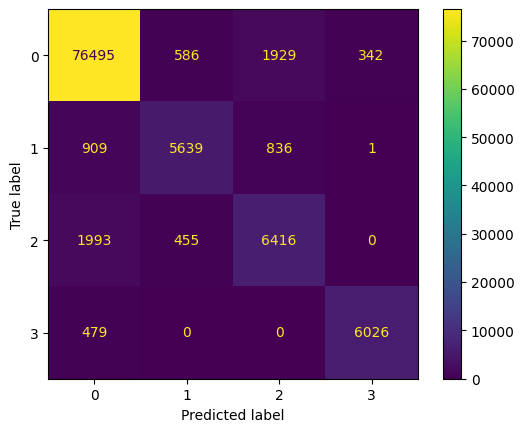

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot()
plt.show()

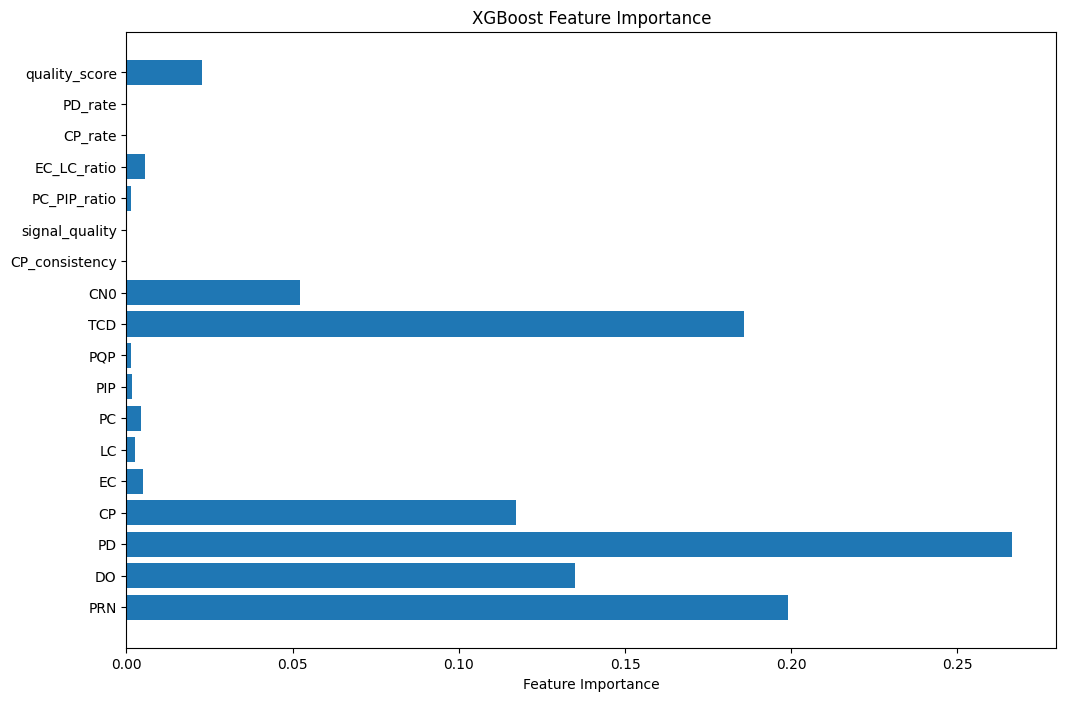

In [17]:
plt.figure(figsize=(12, 8))
plt.barh(features, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()